In [7]:
import os
os.environ['DEVELOPMENT'] = 'True'
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime

from aquacrop import AquaCropModel, Soil, Crop, InitialWaterContent, IrrigationManagement, GroundWater, FieldMngt
from aquacrop.utils import prepare_weather, get_filepath



Setup comparison function

In [39]:
def run_comparison(win_filename, py_model):

    # Get Python daily output
    py_daily_outputs = py_model.get_crop_growth()
    py_daily_outputs['biomass']=py_daily_outputs['biomass']/100
    py_daily_outputs['canopy_cover']=py_daily_outputs['canopy_cover']*100
    py_daily_outputs['dap']=py_daily_outputs['dap'].astype(int)

    start_year=py_model.sim_start_time.split('/')[0]
    start_month,start_day=py_model.crop.planting_date.split('/')
    
    py_daily_outputs['datetime']=py_daily_outputs.apply(lambda x:datetime.datetime(int(x['season_counter']+int(start_year)),int(start_month),int(start_day)+1)+datetime.timedelta(int(x['dap']-1)),axis=1)
    py_daily_outputs['year']=pd.DatetimeIndex(py_daily_outputs['datetime']).year
    py_daily_outputs['month']=pd.DatetimeIndex(py_daily_outputs['datetime']).month
    py_daily_outputs['day']=pd.DatetimeIndex(py_daily_outputs['datetime']).day
    py_daily_outputs['source']='AQ-Py'

    # Get Python annual outputs
    py_annual_outputs = py_model._outputs.final_stats.round(3)
    #py_annual_outputs.columns = ["Season","CropType","datetime","HarvestDate (Step)","dry-yield", "fresh-yield","yield-potential", "Seasonal irrigation (mm)"]
    py_annual_outputs.columns = ["Season","CropType","datetime","HarvestDate (Step)","dry-yield", "Seasonal irrigation (mm)"]
    py_annual_outputs['source']='Py'

    # Get windows daily outputs
    win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT', 
                            skiprows=4, skipfooter=33,  delim_whitespace=True,encoding="latin1")
    win_daily_outputs=win_daily_outputs.drop([0])
    win_daily_outputs.rename(columns={
        'Year': 'year',
        'Month': 'month',
        'Day': 'day',
        },
        inplace=True, 
        errors='raise')

    # drop rows that contain repetitions of the headers throughout the file, one per successive annual run
    def remove_headers(data):
        start_points=data[data.isin(['Day']).any(axis=1)].index # begin row drops where 'Day' is in any col
        end_points = [x+3 for x in start_points] # end 3 lines later
        to_drop=[]
        n=0

        while(n < len(start_points)):
            x=list(range(start_points[n]-1, end_points[n]-1)) # adjust drops, one line before the indexes found previously
            to_drop.extend(x) # add all indexes to drop to a list
            n=n+1

        new_data = data.drop(index=to_drop)

        return new_data

    win_daily_outputs=remove_headers(win_daily_outputs)
    # add datetime column
    win_daily_outputs['datetime'] = pd.to_datetime(win_daily_outputs[['year','month','day']])
    # convert all cols except date-related cols to floats
    win_daily_outputs['CC']=win_daily_outputs['CC'].astype(float)
    cols=win_daily_outputs.columns.drop(['day','month','year','datetime'])
    win_daily_outputs[cols]=win_daily_outputs[cols].apply(pd.to_numeric, errors='coerce')
    # rename cols to align with py col names
    win_daily_outputs.rename(columns={'CC': 'canopy_cover',
                                'Y(dry)': 'Yield',
                                'Biomass': 'biomass',
                                'HI':'harvest_index',
                                },
                    inplace=True, errors='raise')
    win_daily_outputs['harvest_index']=win_daily_outputs['harvest_index']/100
    win_daily_outputs.loc[win_daily_outputs['harvest_index'] < 0, 'harvest_index'] = 0
    win_daily_outputs['source']='AQ-Win'
    win_daily_outputs.to_csv('win-outputs.csv', index = False, encoding='utf-8')

    # Get windows annual outputs
    win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT', 
                                skiprows=4, skipfooter=8,  delim_whitespace=True,encoding="ISO-8859-1")
    win_annual_outputs=win_annual_outputs.drop([0])
    win_annual_outputs=remove_headers(win_annual_outputs)
    win_annual_outputs = win_annual_outputs.iloc[: , :-5] # remove 5 blank cols due to reading error
    win_annual_outputs['datetime']=pd.to_datetime(win_annual_outputs[['Year','Month','Day']])
    win_annual_outputs.columns=['Nr','Day','Month','Year','biomass','dry-yield','fresh-yield', 'datetime']
    win_annual_outputs=win_annual_outputs[win_annual_outputs['Nr'] != '0'] # remove blank rows
    win_annual_outputs['source']='Win'

    # Combine annual outputs
    combined_annual=pd.concat([win_annual_outputs, py_annual_outputs])
    combined_annual['dry-yield']=combined_annual['dry-yield'].astype(float)

    # Combine daily outputs
    both_daily_outputs=pd.concat([win_daily_outputs, py_daily_outputs])

    g1=sns.lineplot(data=both_daily_outputs, x='datetime',y='canopy_cover', hue='source')
    sns.move_legend(g1, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
    plt.show()
    #g.set_yticks(range(0,110,10), labels=range(0,110,10)) 
    g2=sns.lineplot(data=both_daily_outputs, x='datetime',y='biomass', hue='source')
    sns.move_legend(g2, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
    plt.show()
    g2b=sns.lineplot(data=both_daily_outputs, x='datetime',y='harvest_index', hue='source')
    sns.move_legend(g2b, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
    plt.show()
    g3=sns.lineplot(data=combined_annual.reset_index(), x='datetime', y='dry-yield', hue='source')
    sns.move_legend(g3, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
    plt.show()
    

Exercise 7.1 with Tunis Local soil

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\1543998061.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\1543998061.py:72: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


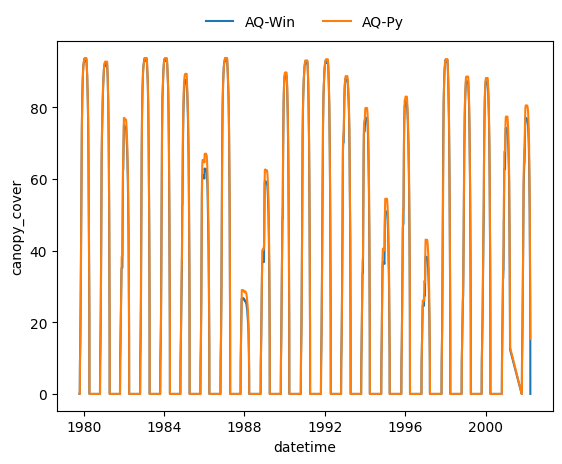

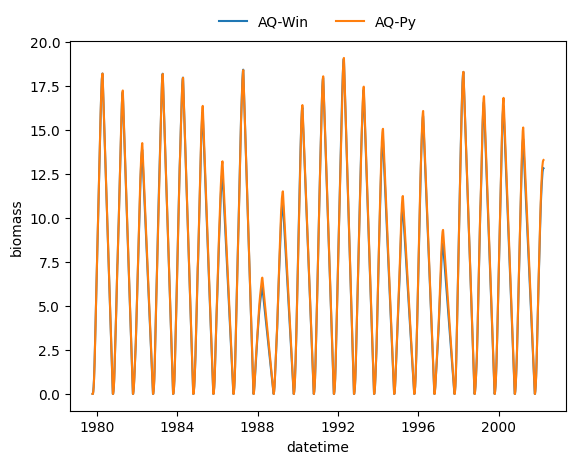

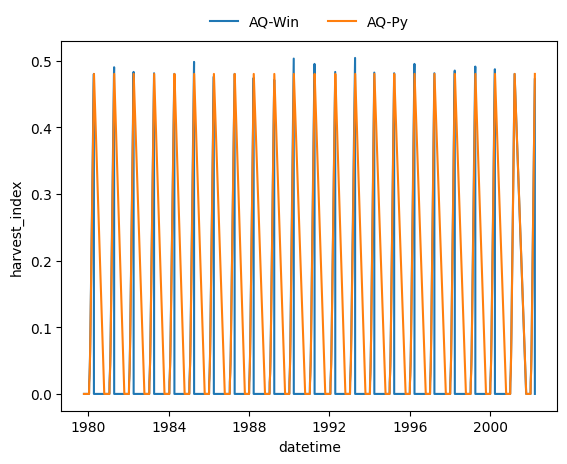

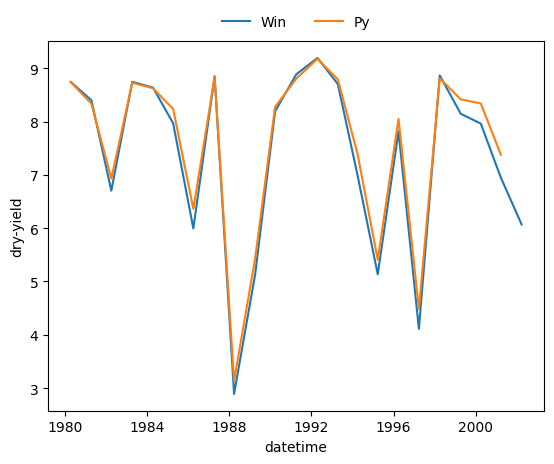

In [40]:
# Tunis climate
filepath=get_filepath('tunis_climate.txt')
weather_data = prepare_weather(filepath)

# Local Tunis soil
tunis_soil = Soil(soil_type='ac_TunisLocal')

# crops
wheat = Crop('WheatGDD', planting_date='10/15')

# IWC
wet_dry = InitialWaterContent(wc_type='Num',
                              method='Depth',
                              depth_layer=[0.3,0.9],
                              value=[0.3,0.15])

# irr management
irr_mngt = IrrigationManagement(irrigation_method=0)

model = AquaCropModel(sim_start_time=f'{1979}/10/15',
                      sim_end_time=f'{2002}/03/24',
                      weather_df=weather_data,
                      soil=tunis_soil,
                      crop=wheat,
                      irrigation_management=irr_mngt,
                      initial_water_content=wet_dry,
                      )
model.run_model(till_termination=True)

run_comparison('Tun_WW_LocalSoil', model)

Exercise 7.1 with Sandy Loam

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:71: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


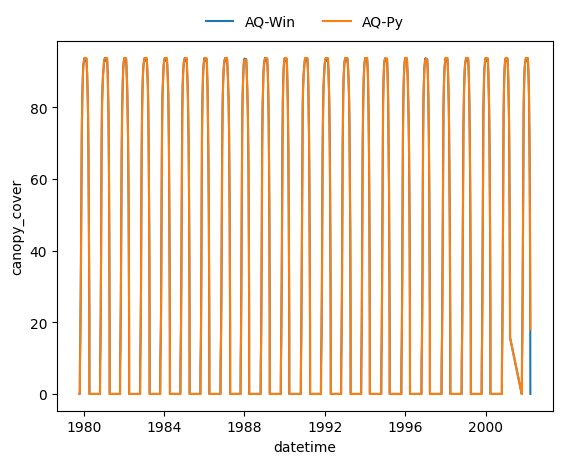

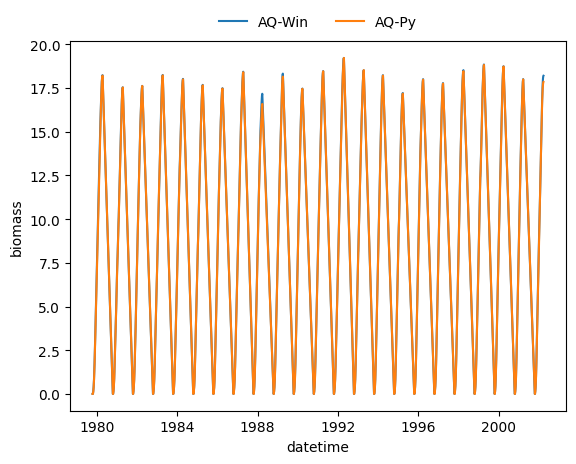

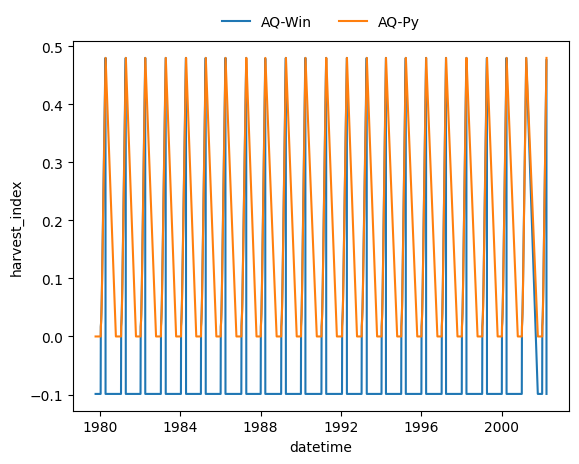

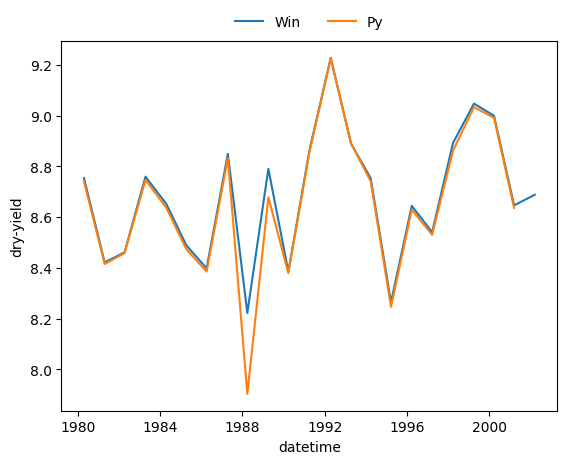

In [10]:
# Sandy loam soil
sandy_loam = Soil(soil_type='SandyLoam')

model = AquaCropModel(sim_start_time=f'{1979}/10/15',
                      sim_end_time=f'{2002}/03/24',
                      weather_df=weather_data,
                      soil=sandy_loam,
                      crop=wheat,
                      irrigation_management=irr_mngt,
                      initial_water_content=wet_dry,
                      )
model.run_model(till_termination=True)

run_comparison('Tun_WW_SLSoil', model)

Exercise 7.2 Local wheat variety

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\1543998061.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\1543998061.py:72: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


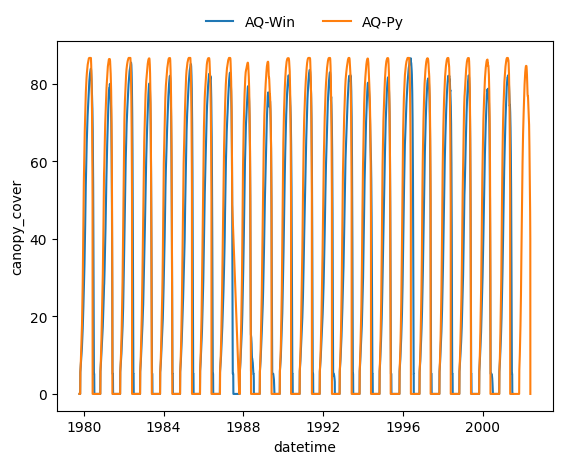

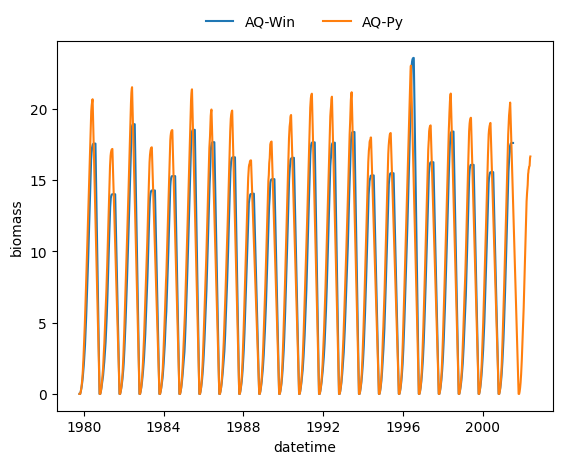

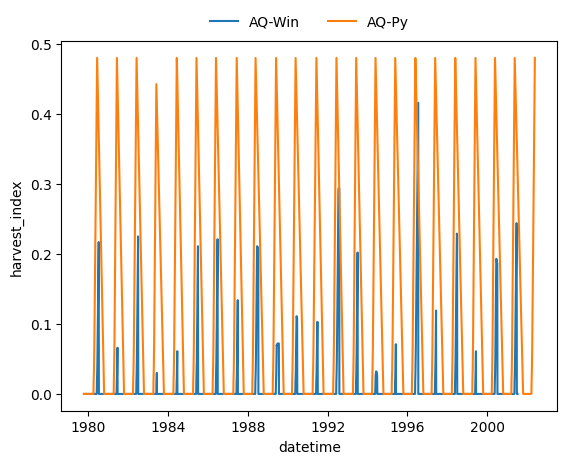

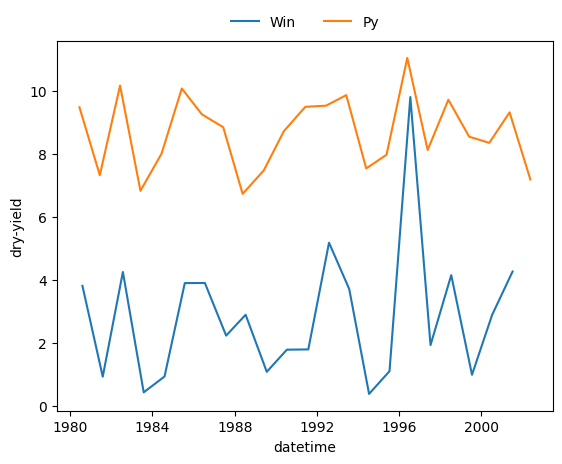

In [41]:
# Local wheat variety
#local_wheat=Crop('WheatLongGDD', planting_date= '10/15')
local_wheat = Crop('WheatGDD',planting_date= '10/15',
                        Emergence=289, 
                        MaxRooting = 1322,
                        Senescence = 2835, 
                        Maturity = 3390,
                        HIstart = 2252,
                        Flowering = 264,
                        YldForm = 1073,
                        PlantPop=3_500_000,
                        CCx=0.9,
                        CDC=0.003888,
                        CGC=0.002734)
model = AquaCropModel(sim_start_time=f'{1979}/10/15',
                      sim_end_time=f'{2002}/05/31',
                      weather_df=weather_data,
                      soil=sandy_loam,
                      crop=local_wheat,
                      irrigation_management=irr_mngt,
                      initial_water_content=wet_dry,
                      )
model.run_model(till_termination=True)

run_comparison('Tun_WW_LongVar', model)

# check windows parameters for this, should match Python
# # double checked windows parameters, re-made custom crop and still the same results (low yield, ~ 4 t/ha)

Exercise 7.3 Different initial conditions

WetDry

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:71: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


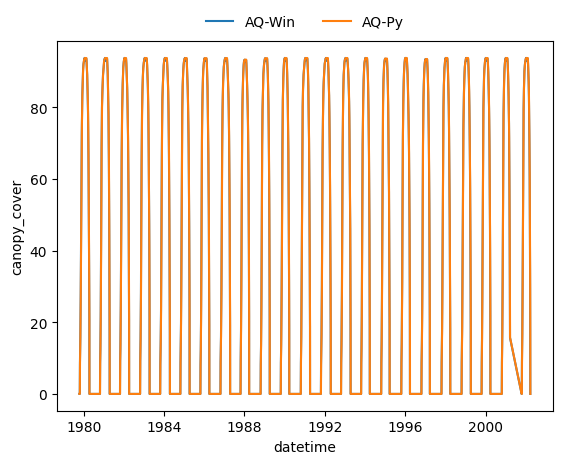

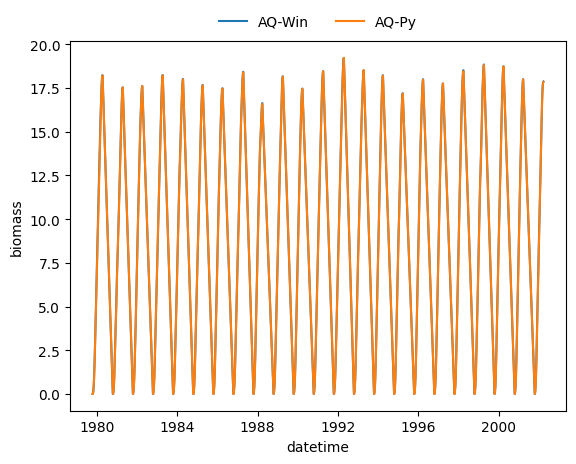

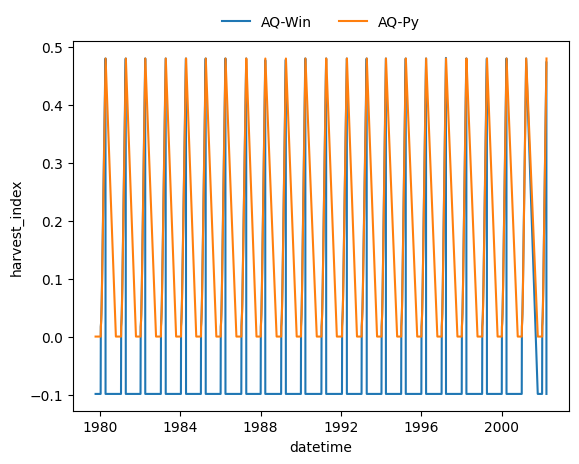

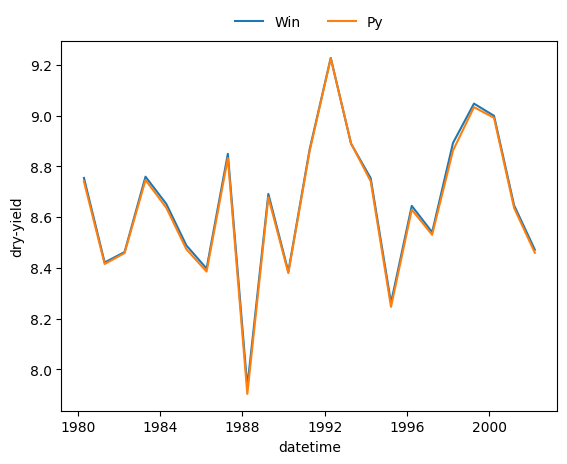

In [12]:
model = AquaCropModel(sim_start_time=f'{1979}/10/15',
                      sim_end_time=f'{2002}/05/31',
                      weather_df=weather_data,
                      soil=sandy_loam,
                      crop=wheat,
                      irrigation_management=irr_mngt,
                      initial_water_content=wet_dry,
                      )
model.run_model(till_termination=True)
run_comparison('Tun_WW_WetDry', model)

Field Capacity:

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:71: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


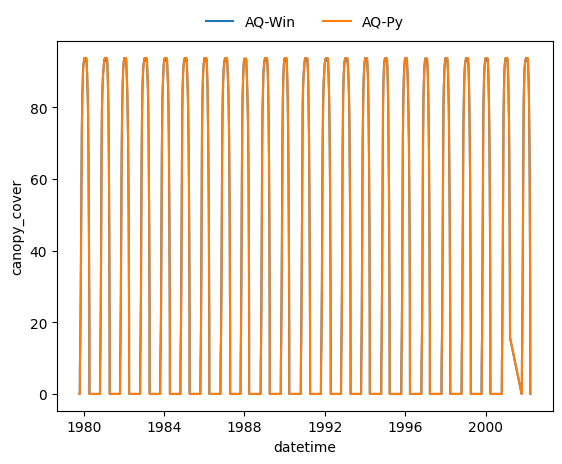

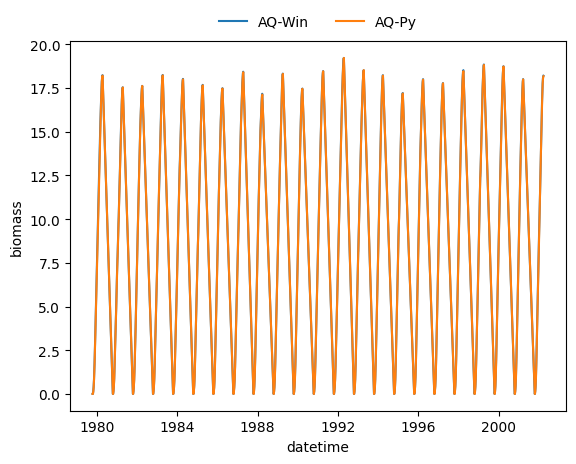

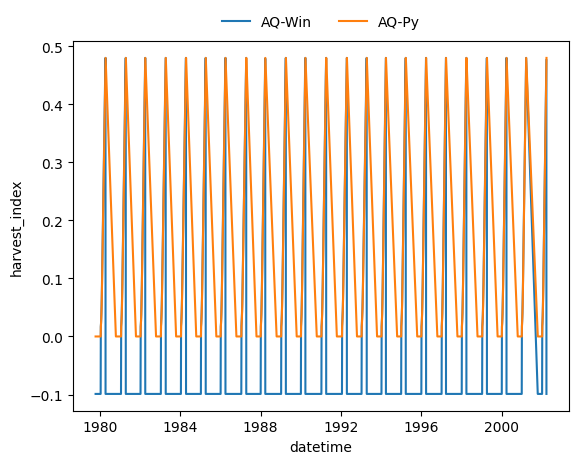

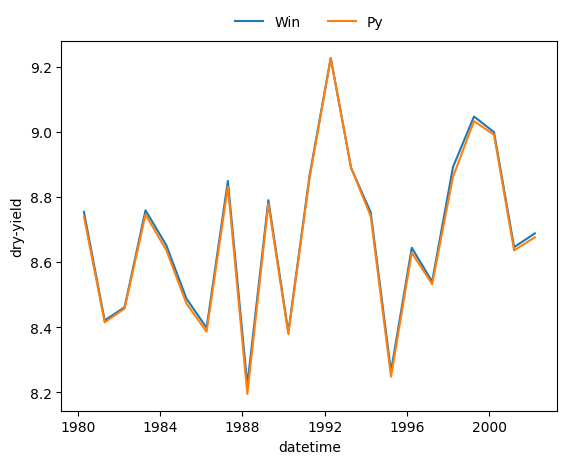

In [13]:
# Change initial water content 
field_capacity = InitialWaterContent(value=['FC'])

model = AquaCropModel(sim_start_time=f'{1979}/10/15',
                      sim_end_time=f'{2002}/05/31',
                      weather_df=weather_data,
                      soil=sandy_loam,
                      crop=wheat,
                      irrigation_management=irr_mngt,
                      initial_water_content=field_capacity,
                      )
model.run_model(till_termination=True)
run_comparison('Tun_WW_FC', model)

30% TAW

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:71: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


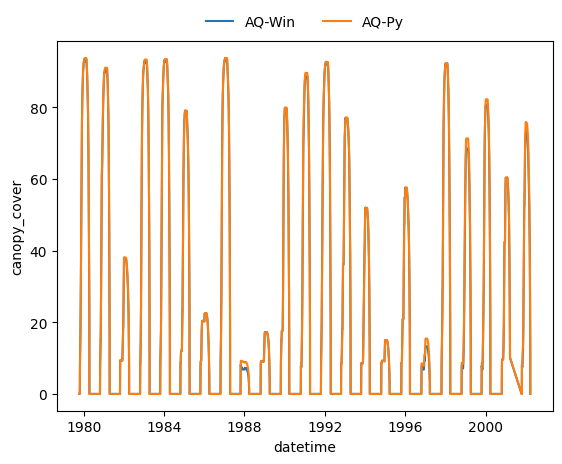

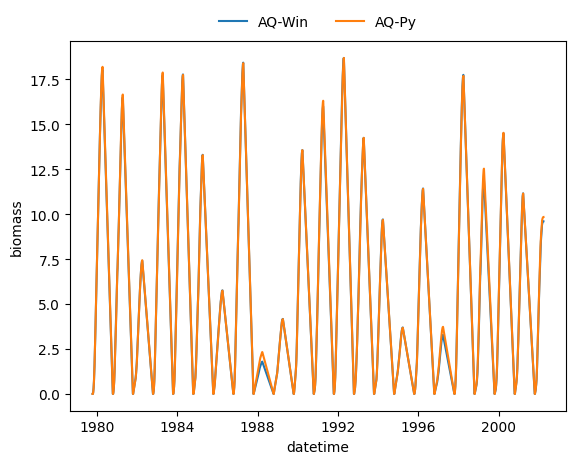

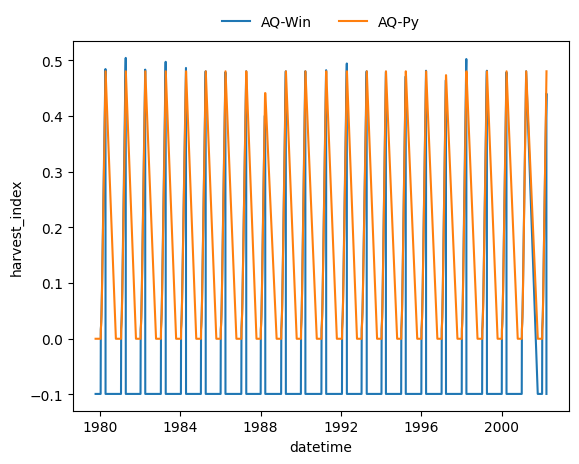

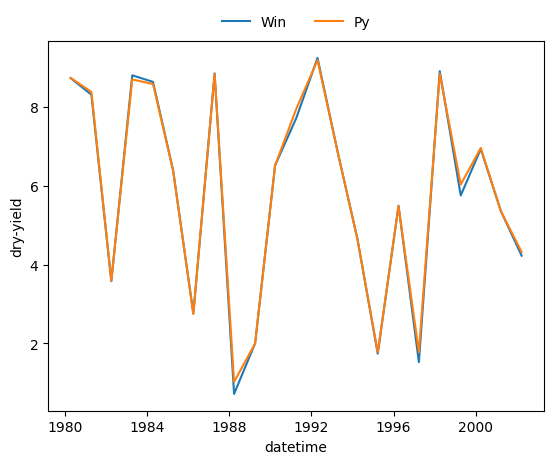

In [14]:
# Change initial water content
iwc30taw = InitialWaterContent('Pct','Layer',[1],[30])

model = AquaCropModel(sim_start_time=f'{1979}/10/15',
                      sim_end_time=f'{2002}/05/31',
                      weather_df=weather_data,
                      soil=sandy_loam,
                      crop=wheat,
                      irrigation_management=irr_mngt,
                      initial_water_content=iwc30taw,
                      )
model.run_model(till_termination=True)
run_comparison('Tun_WW_30TAW', model)

75% TAW

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:71: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


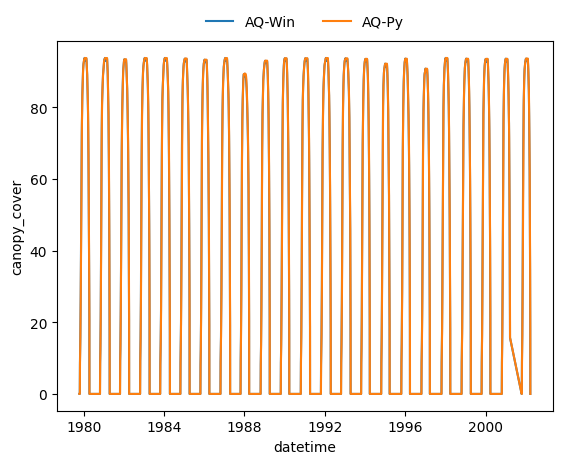

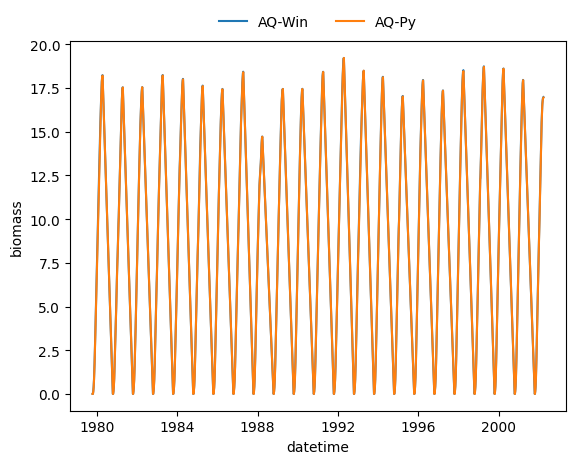

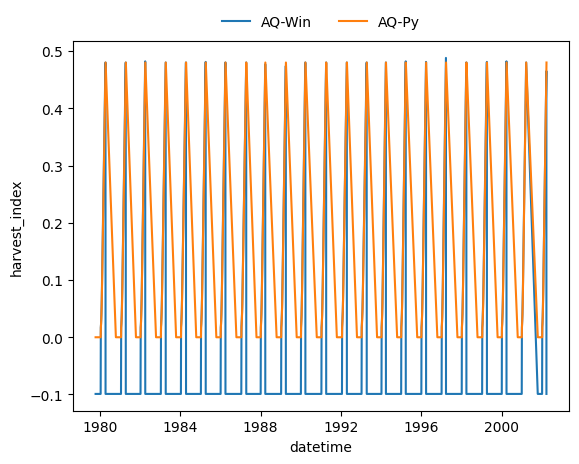

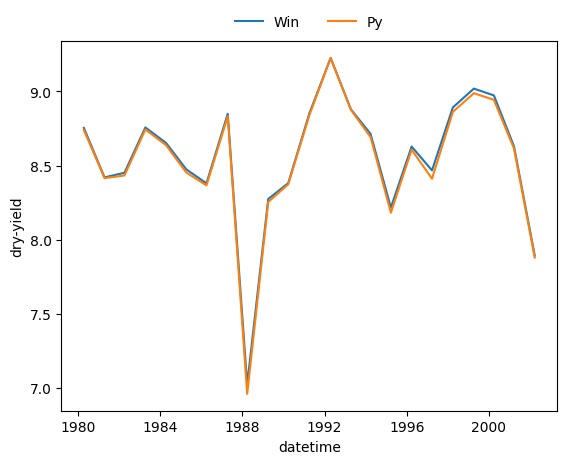

In [15]:
# Change initial water content
iwc75taw = InitialWaterContent('Pct','Layer',[1],[75])

model = AquaCropModel(sim_start_time=f'{1979}/10/15',
                      sim_end_time=f'{2002}/05/31',
                      weather_df=weather_data,
                      soil=sandy_loam,
                      crop=wheat,
                      irrigation_management=irr_mngt,
                      initial_water_content=iwc75taw,
                      )
model.run_model(till_termination=True)
run_comparison('Tun_WW_75TAW', model)

Exercise 7.6 Net irrigation requirement

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:71: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


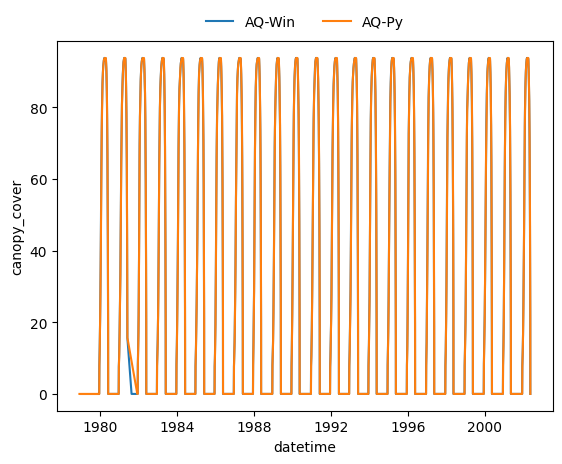

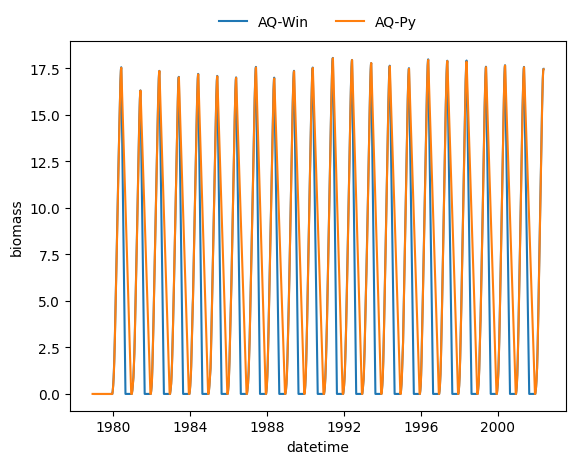

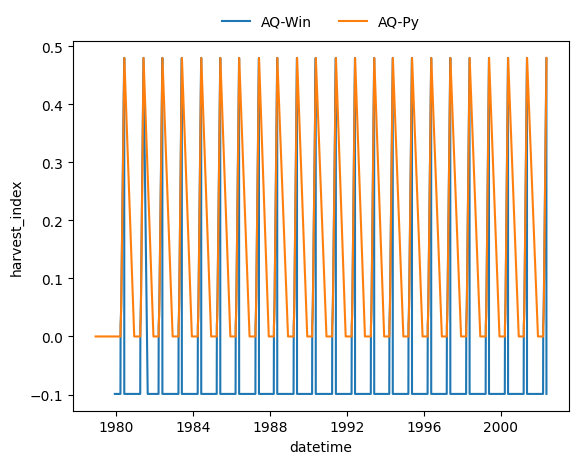

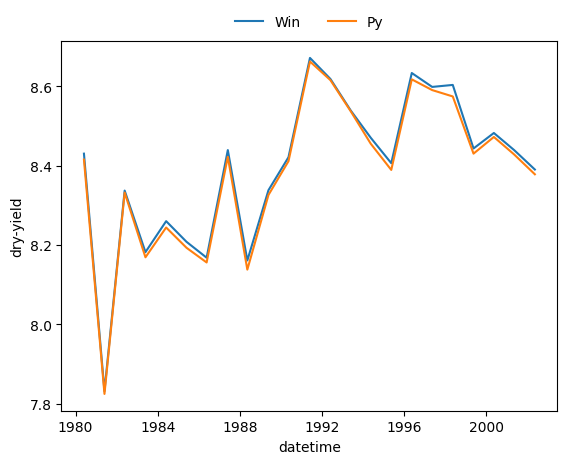

In [16]:
net_irr = IrrigationManagement(irrigation_method=4,net_irr=78.26)
wp = InitialWaterContent(value=['WP'])
wheat_dec = Crop('WheatGDD',planting_date='12/01',harvest_date='07/30')

model = AquaCropModel(sim_start_time=f'{1979}/08/15',
                      sim_end_time=f'{2002}/05/31',
                      weather_df=weather_data,
                      soil=sandy_loam,
                      crop=wheat_dec,
                      irrigation_management=net_irr,
                      initial_water_content=wp,
                      )
model.run_model(till_termination=True)

run_comparison('Tun_WW_NetIrr', model)

Exercise 7.7 Assess deficit irrigation schedules

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:71: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


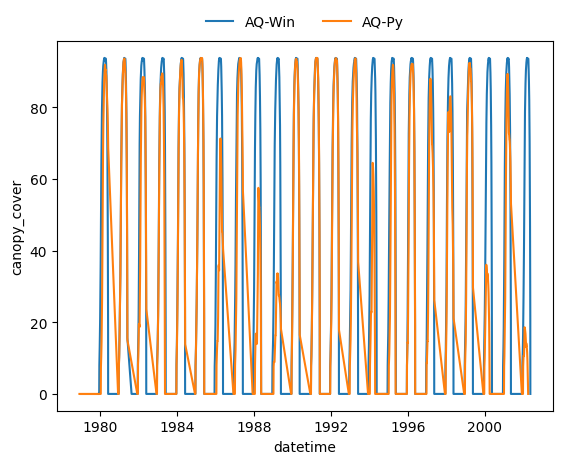

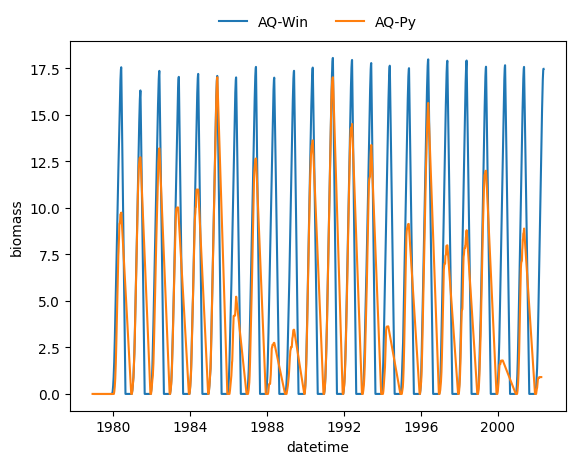

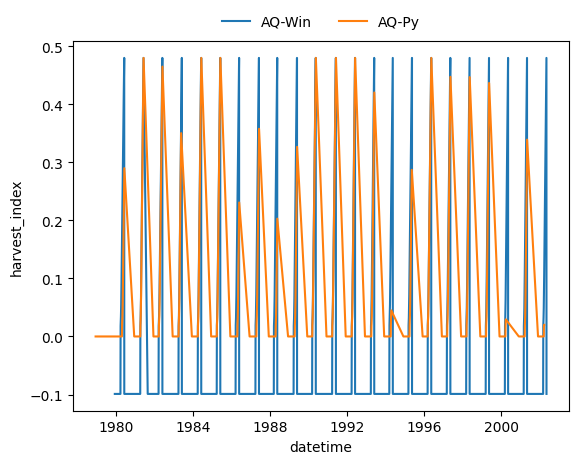

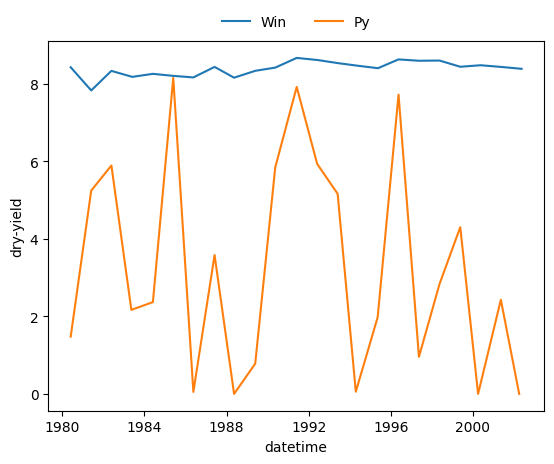

In [17]:
all_days=pd.date_range('1979/12/01', '2001/12/01',freq='12MS')

dates=[]

for each_start in all_days:
    app1=each_start
    app2=each_start+pd.Timedelta(30,'d')
    app3=each_start+pd.Timedelta(60,'d')
    dates.extend([app1,app2,app3])

n_years=len(all_days)
depths=[30,40,40]*n_years

schedule=pd.DataFrame([dates,depths]).T # create pandas DataFrame
schedule.columns=['Date','Depth'] # name columns

net_irr = IrrigationManagement(irrigation_method=5, Schedule=schedule)
wp = InitialWaterContent(value=['WP'])
wheat_dec = Crop('WheatGDD',planting_date='12/01',harvest_date='07/30')

model = AquaCropModel(sim_start_time=f'{1979}/08/15',
                      sim_end_time=f'{2002}/05/31',
                      weather_df=weather_data,
                      soil=sandy_loam,
                      crop=wheat_dec,
                      irrigation_management=net_irr,
                      initial_water_content=wp,
                      )
model.run_model(till_termination=True)

run_comparison('Tun_WW_NetIrr', model)

Exercise 8.2 Paddy rice in Hyderabad planting dates

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:71: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


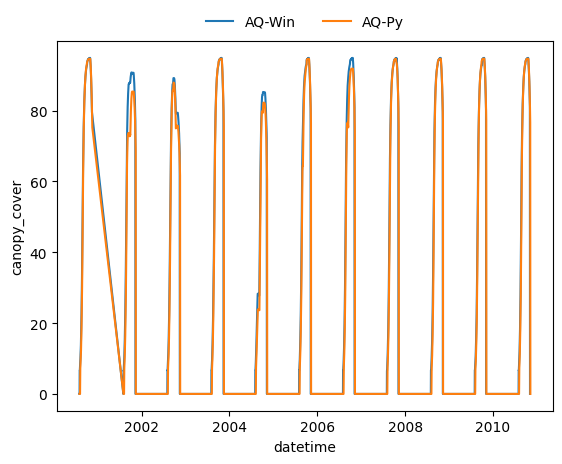

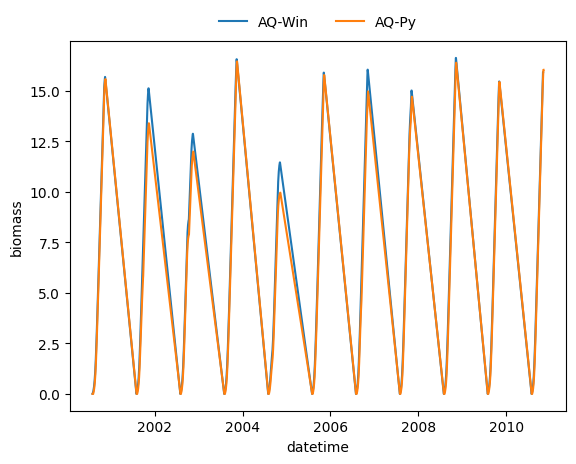

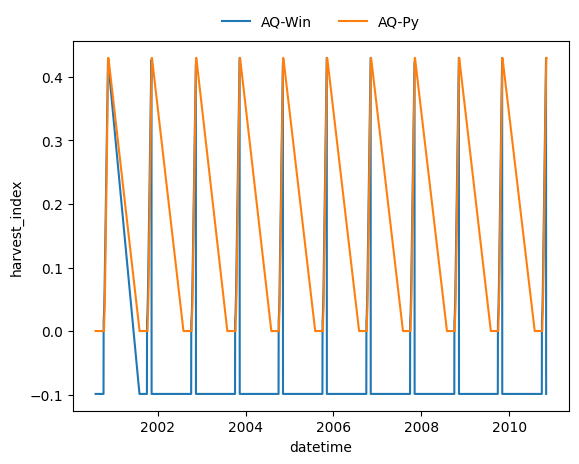

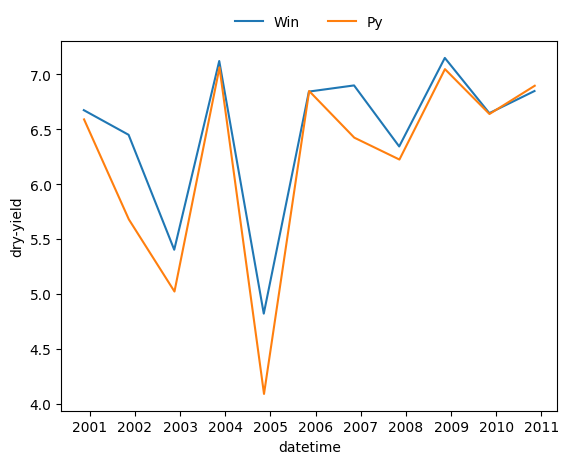

In [18]:
# Hyderabad climate
filepath=get_filepath('hyderabad_climate.txt')
hyderabad_weather = prepare_weather(filepath)

# Hyderabad soil
paddy_soil = Soil(soil_type='Paddy')

# crop
local_rice = Crop('localpaddy', planting_date='08/01')

# IWC
fc = InitialWaterContent(value=['FC'])

# irr management
irr_mngt = IrrigationManagement(irrigation_method=0)

# field management
bunds20 = FieldMngt(bunds=True, z_bund=0.20)

model = AquaCropModel(sim_start_time=f'{2000}/08/01',
                      sim_end_time=f'{2010}/12/31',
                      weather_df=hyderabad_weather,
                      soil=paddy_soil,
                      crop=local_rice,
                      field_management=bunds20,
                      irrigation_management=irr_mngt,
                      initial_water_content=fc,
                      )
model.run_model(till_termination=True)

run_comparison('Hyd_Rice_1Aug', model)

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:71: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


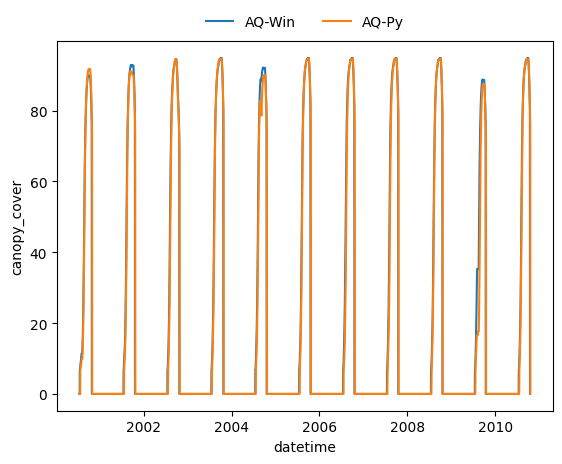

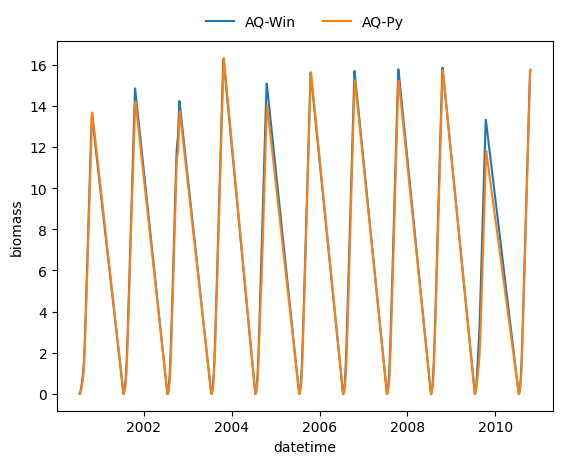

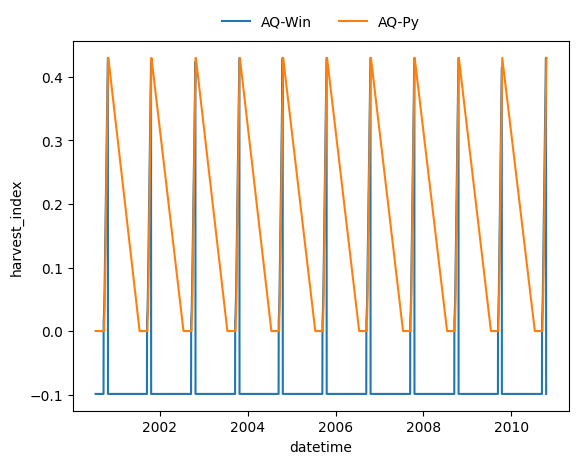

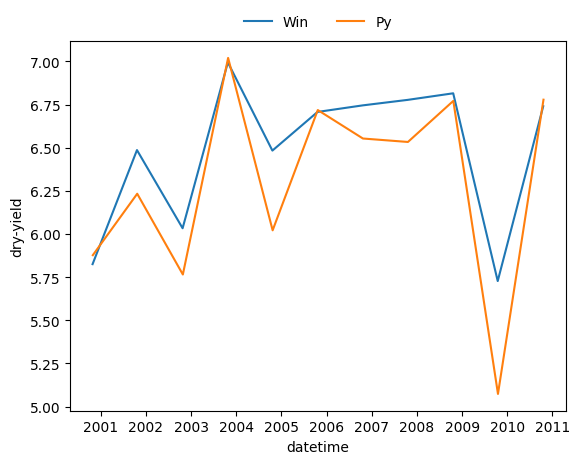

In [19]:
# crop
local_rice = Crop('localpaddy', planting_date='07/15')

model = AquaCropModel(sim_start_time=f'{2000}/07/15',
                      sim_end_time=f'{2010}/12/31',
                      weather_df=hyderabad_weather,
                      soil=paddy_soil,
                      crop=local_rice,
                      field_management=bunds20,
                      irrigation_management=irr_mngt,
                      initial_water_content=fc,
                      )
model.run_model(till_termination=True)

run_comparison('Hyd_Rice_15Jul', model)

Exercise 8.3 Initial conditions

Field capacity

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:71: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


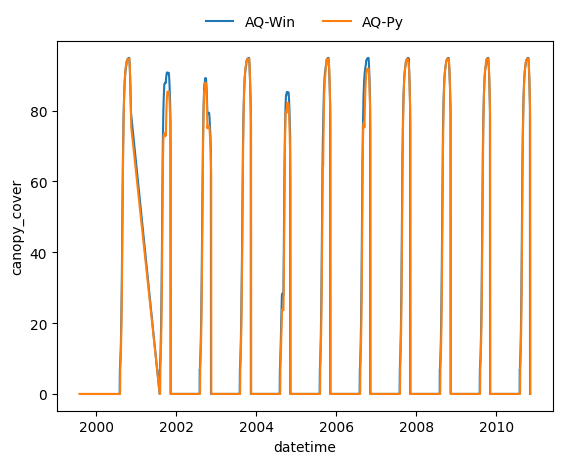

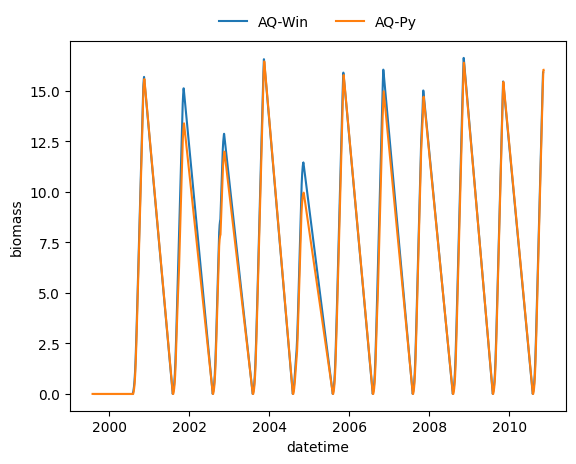

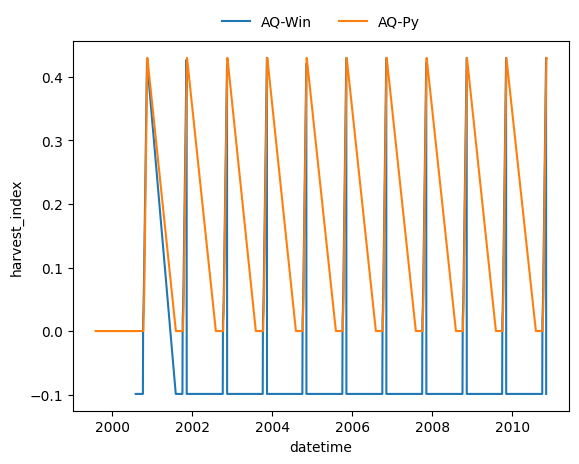

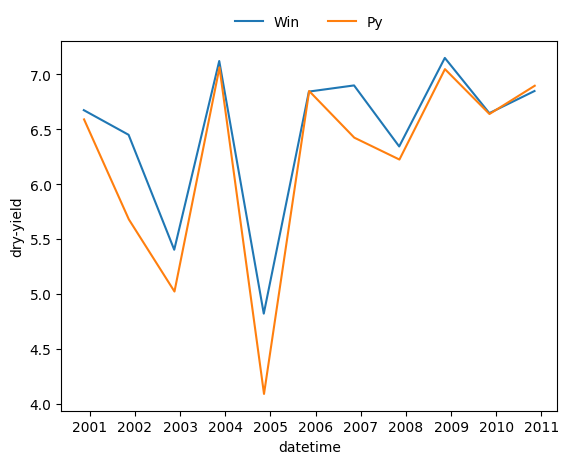

In [20]:
# Hyderabad climate
filepath=get_filepath('hyderabad_climate.txt')
hyderabad_weather = prepare_weather(filepath)

# Local Brussels soil
paddy_soil = Soil(soil_type='Paddy')

# crop
local_rice = Crop('localpaddy', planting_date='08/01')

# IWC
fc = InitialWaterContent(value=['FC'])

# irr management
irr_mngt = IrrigationManagement(irrigation_method=0)

model = AquaCropModel(sim_start_time=f'{2000}/01/01',
                      sim_end_time=f'{2010}/12/31',
                      weather_df=hyderabad_weather,
                      soil=paddy_soil,
                      crop=local_rice,
                      irrigation_management=irr_mngt,
                      field_management=bunds20,
                      initial_water_content=fc,
                      )
model.run_model(till_termination=True)

run_comparison('Hyd_Rice_FC', model)

30% TAW

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:71: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


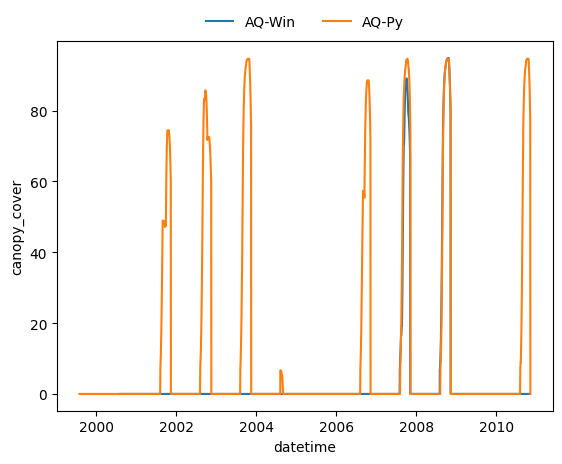

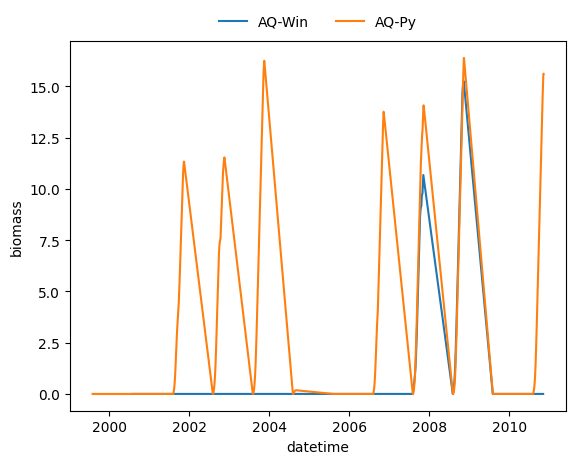

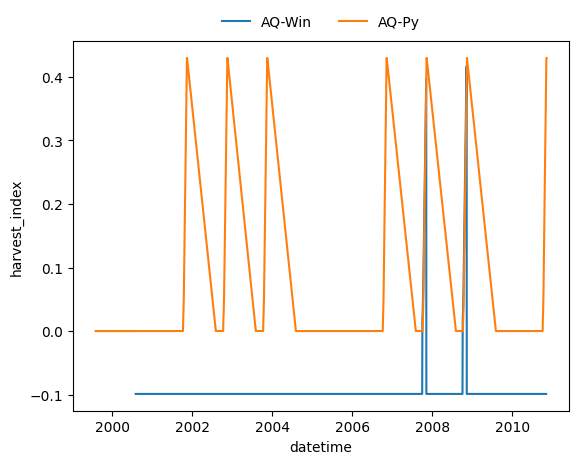

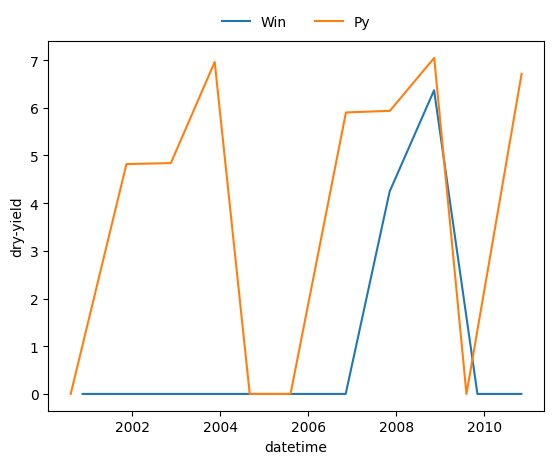

In [21]:
# IWC
taw30 = InitialWaterContent('Pct','Layer',[1],[30])
model = AquaCropModel(sim_start_time=f'{2000}/01/01',
                      sim_end_time=f'{2010}/12/31',
                      weather_df=hyderabad_weather,
                      soil=paddy_soil,
                      crop=local_rice,
                      irrigation_management=irr_mngt,
                      field_management=bunds20,
                      initial_water_content=taw30,
                      )
model.run_model(till_termination=True)

run_comparison('Hyd_Rice_30TAW', model)

75% TAW

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:71: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


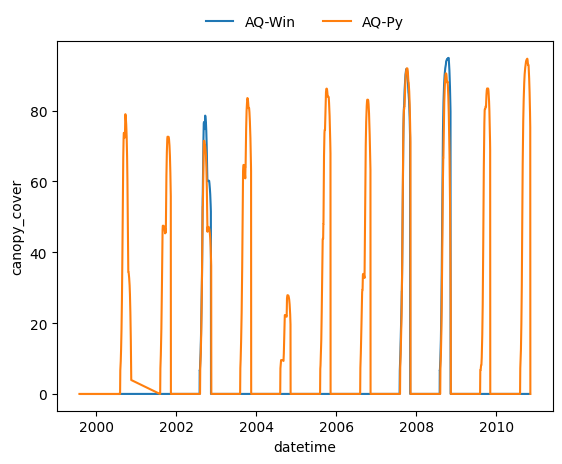

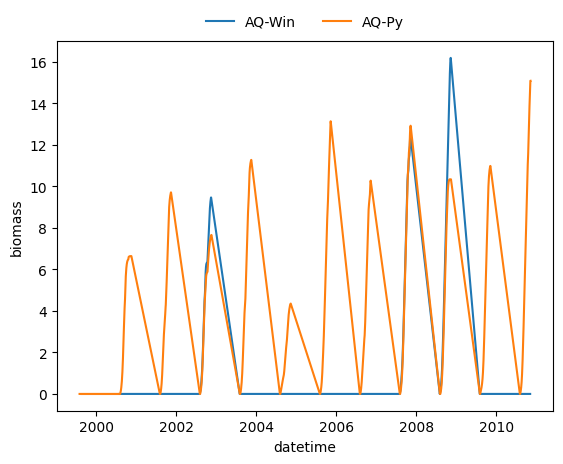

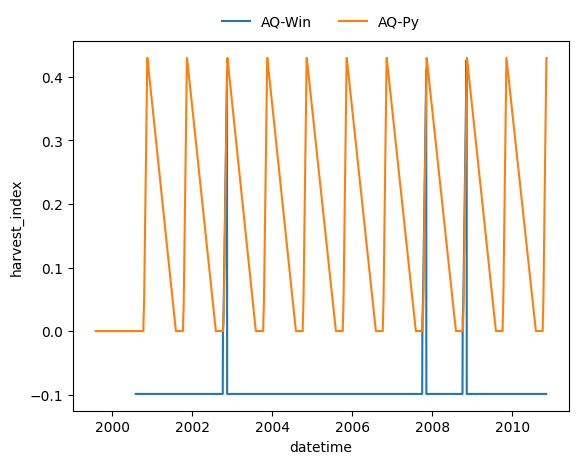

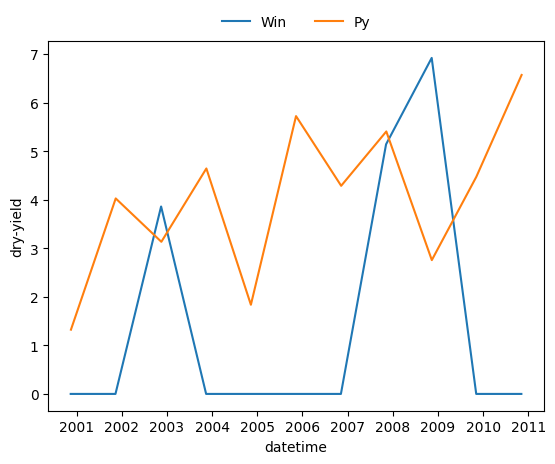

In [22]:
# IWC
taw75 = InitialWaterContent('Pct','Layer',[1],[75])

model = AquaCropModel(sim_start_time=f'{2000}/01/01',
                      sim_end_time=f'{2010}/12/31',
                      weather_df=hyderabad_weather,
                      soil=paddy_soil,
                      crop=local_rice,
                      irrigation_management=irr_mngt,
                      initial_water_content=taw75,
                      )
model.run_model(till_termination=True)

run_comparison('Hyd_Rice_75TAW', model)

Wet Top

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:71: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


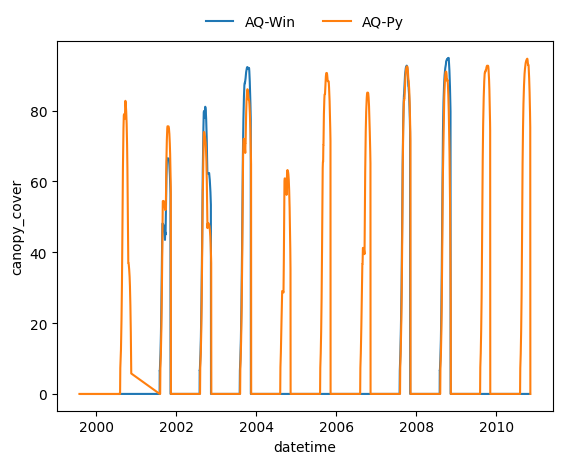

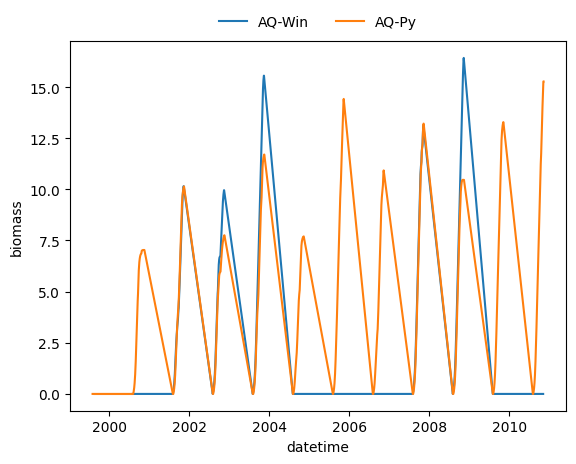

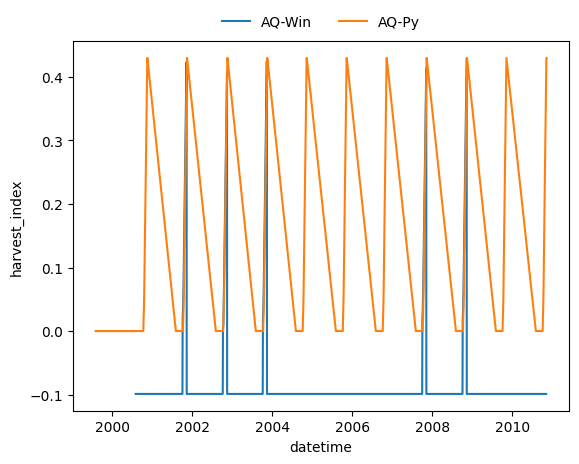

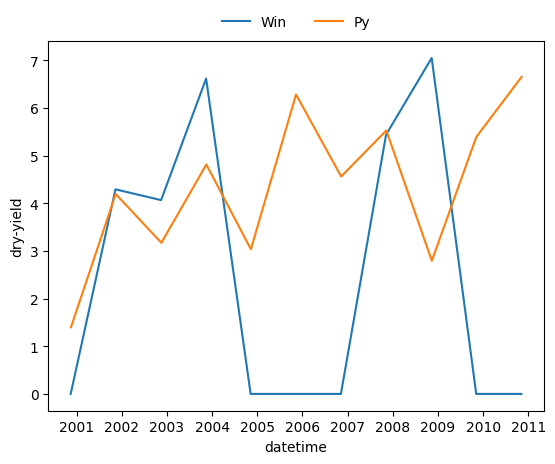

In [23]:
# IWC
wetTop = InitialWaterContent('Prop','Depth',[0.5,2],['FC','WP']) # add FC as num from soil profile.py, check these numbers with v7 windows file

model = AquaCropModel(sim_start_time=f'{2000}/01/01',
                      sim_end_time=f'{2010}/12/31',
                      weather_df=hyderabad_weather,
                      soil=paddy_soil,
                      crop=local_rice,
                      irrigation_management=irr_mngt,
                      initial_water_content=wetTop,
                      )
model.run_model(till_termination=True)

run_comparison('Hyd_Rice_wetTop', model)

Exercise 9.1 Potato in Brussels

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:71: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


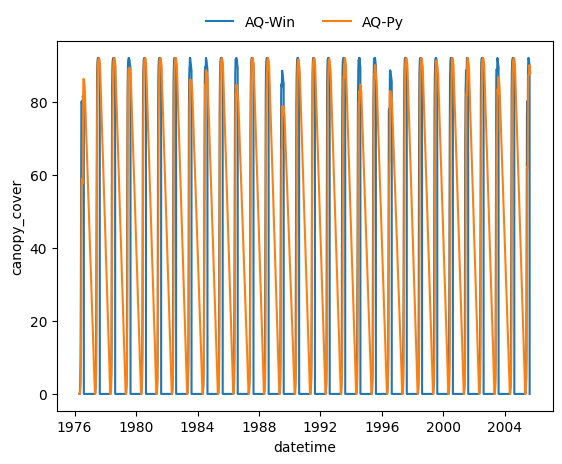

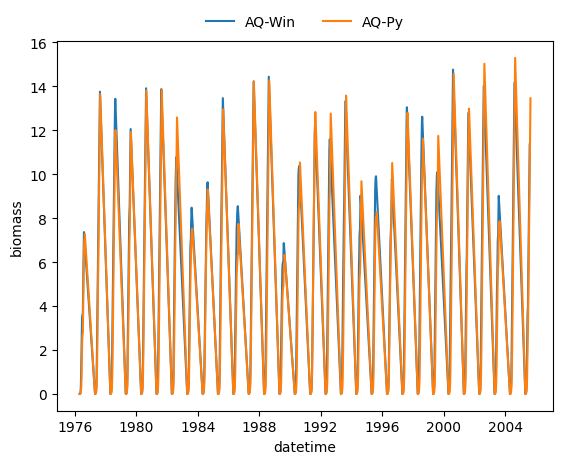

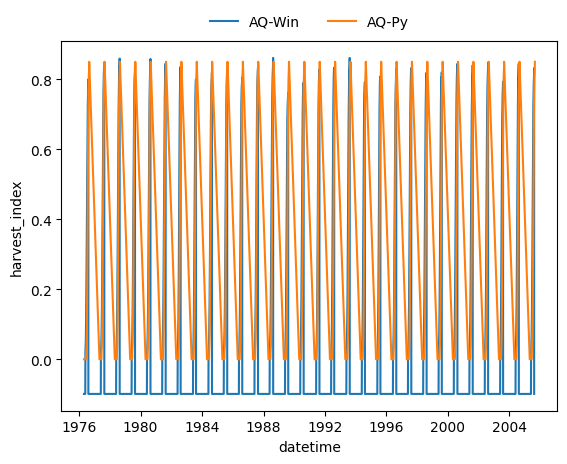

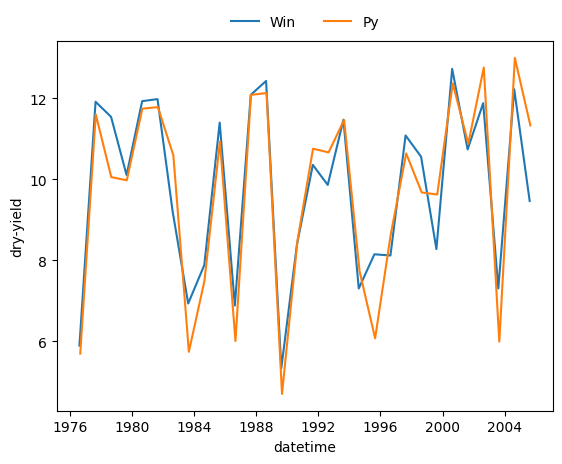

In [24]:
# Brussels climate
filepath=get_filepath('brussels_climate.txt')
brussels_weather = prepare_weather(filepath)

# Local Brussels soil
loam_soil = Soil(soil_type='Loam')

# crops
potato = Crop('PotatoLocal', planting_date='04/25')

# IWC
fc = InitialWaterContent(value=['FC'])

# irr management
irr_mngt = IrrigationManagement(irrigation_method=0)

model = AquaCropModel(sim_start_time=f'{1976}/04/25',
                      sim_end_time=f'{2005}/12/31',
                      weather_df=brussels_weather,
                      soil=loam_soil,
                      crop=potato,
                      irrigation_management=irr_mngt,
                      initial_water_content=fc,
                      )
model.run_model(till_termination=True)

run_comparison('Bru_Pot', model)

9.4 Net irrigation requirement

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\1543998061.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\1543998061.py:72: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


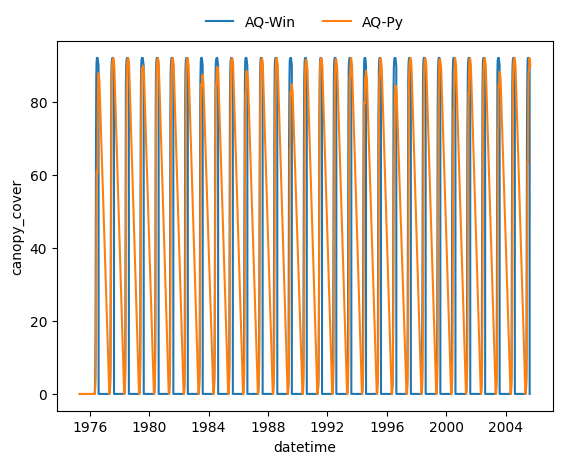

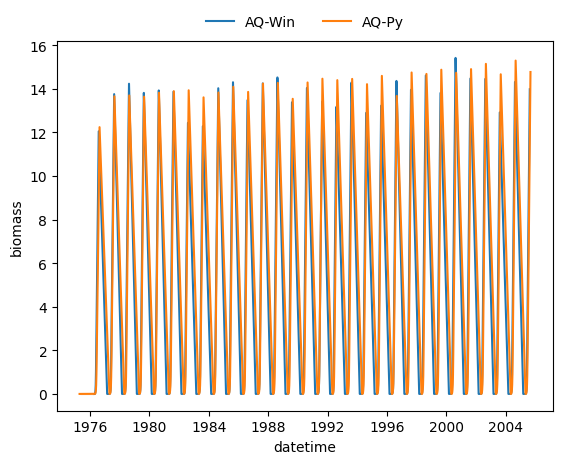

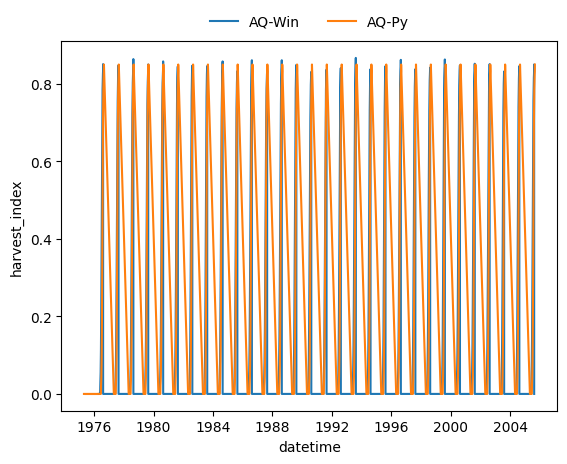

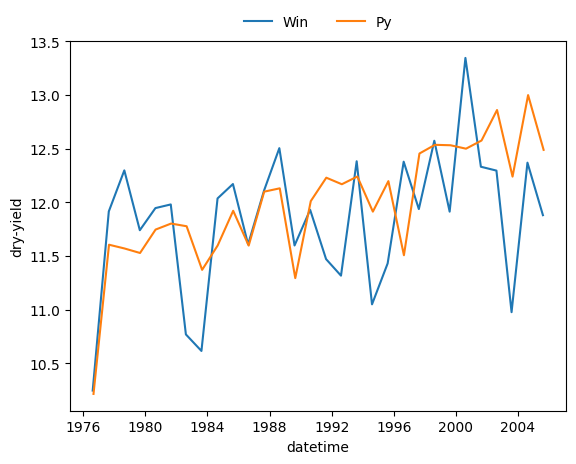

In [48]:
net_irr = IrrigationManagement(irrigation_method=4,NetIrrSMT=21)

model = AquaCropModel(sim_start_time=f'{1976}/03/01',
                      sim_end_time=f'{2005}/12/31',
                      weather_df=brussels_weather,
                      soil=loam_soil,
                      crop=potato,
                      irrigation_management=net_irr,
                      initial_water_content=fc,
                      )
model.run_model(till_termination=True)

run_comparison('Bru_Pot_NetIrr', model)

9.5 Generating irrigation schedules

In [26]:
# function to return the irrigation depth to apply on next day
def get_depth(model, raw):    
    t = model._clock_struct.time_step_counter # current timestep
    if t>0 and model._init_cond.depletion/model._init_cond.taw > raw:
        depth=15
    else:
        depth=0

    return depth

36% RAW allowable depletion

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\1543998061.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\1543998061.py:72: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


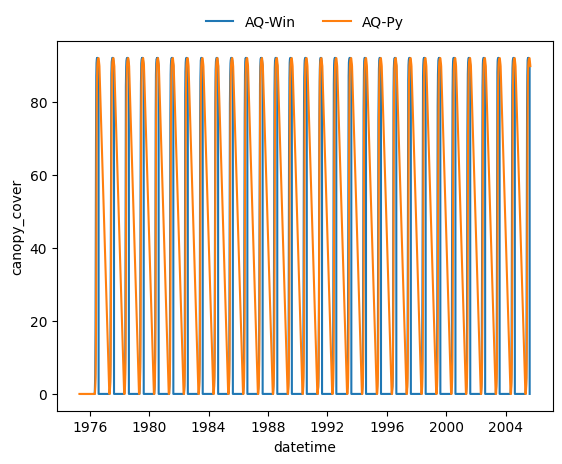

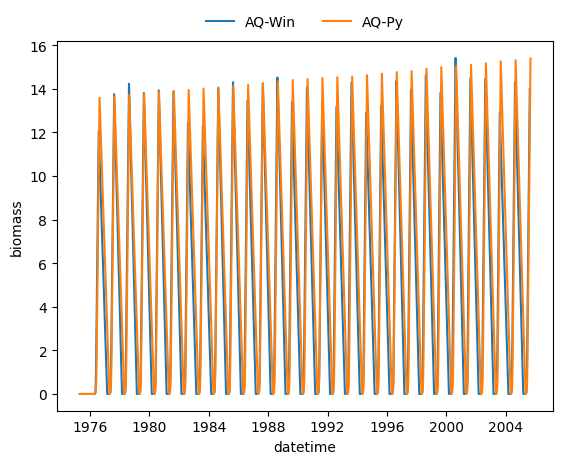

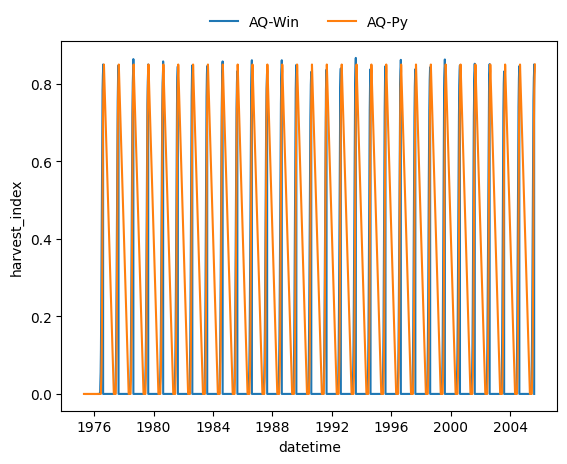

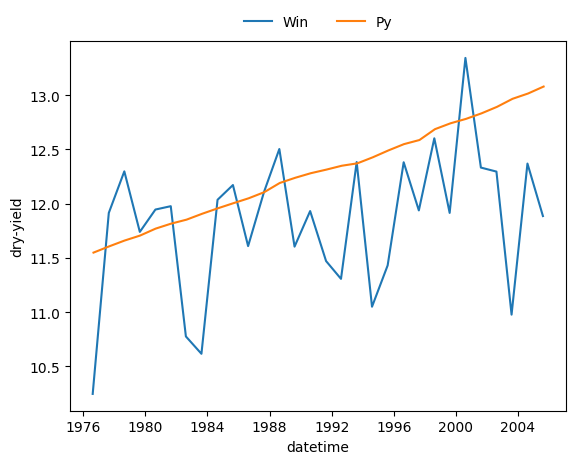

In [43]:
# Loamy sand soil
loamy_sand = Soil(soil_type='LoamySand')

# crop
potato = Crop('PotatoLocal', planting_date='04/25')

# create model with IrrMethod= Constant depth
model = AquaCropModel(sim_start_time=f'{1976}/03/01',
                      sim_end_time=f'{2005}/12/31',
                      weather_df=brussels_weather,
                      soil=loamy_sand,
                      crop=potato,
                      irrigation_management=IrrigationManagement(irrigation_method=5,),
                      initial_water_content=fc,
                      )
                       

model._initialize()

while model._clock_struct.model_is_finished is False:    
    # get depth to apply
    depth=get_depth(model,0.18)
    
    model._param_struct.IrrMngt.depth=depth

    model.run_model(initialize_model=False)

run_comparison('Bru_Pot_Irr36RAW', model)

100% RAW

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:71: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


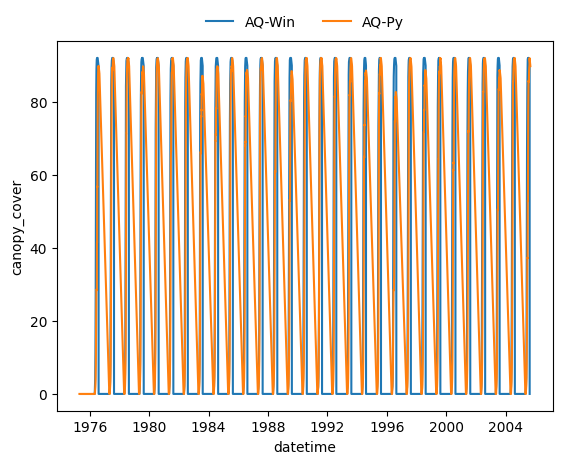

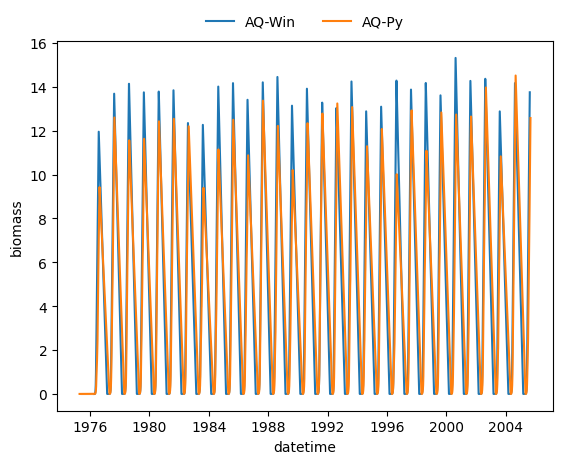

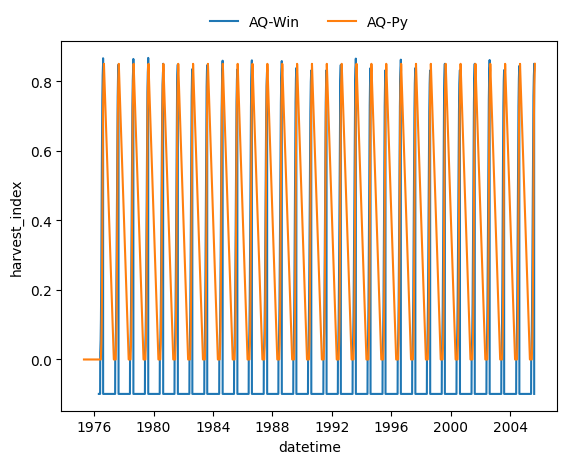

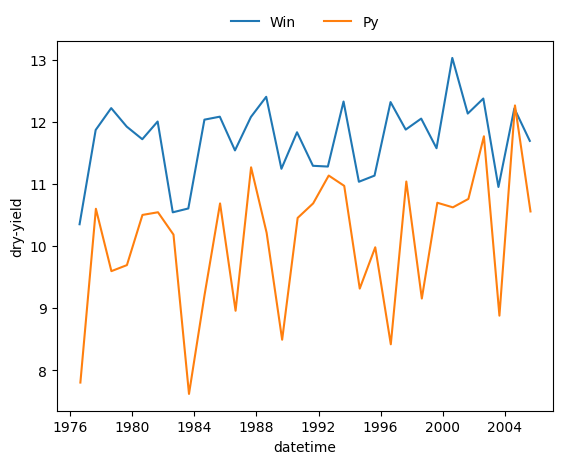

In [28]:
# create model with IrrMethod= Constant depth
model = AquaCropModel(sim_start_time=f'{1976}/03/01',
                      sim_end_time=f'{2005}/12/31',
                      weather_df=brussels_weather,
                      soil=loamy_sand,
                      crop=potato,
                      irrigation_management=IrrigationManagement(irrigation_method=5,),
                      initial_water_content=fc,
                      )
                       

model._initialize()

while model._clock_struct.model_is_finished is False:    
    # get depth to apply
    depth=get_depth(model,1)
    
    model._param_struct.IrrMngt.depth=depth

    model.run_model(initialize_model=False)

run_comparison('Bru_Pot_Irr100RAW', model)

150% RAW

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:71: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


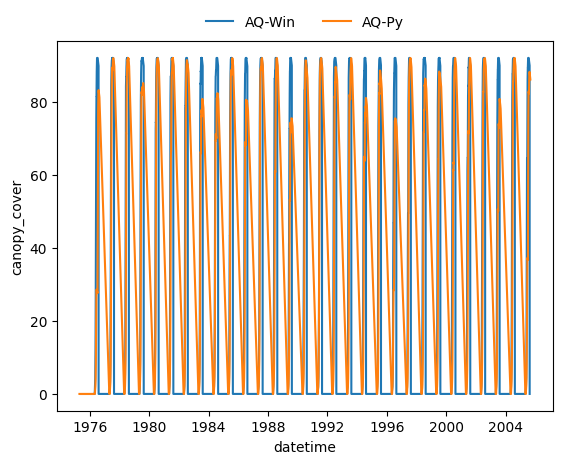

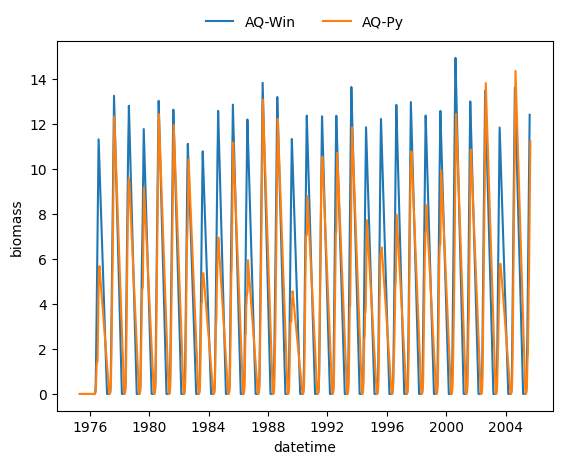

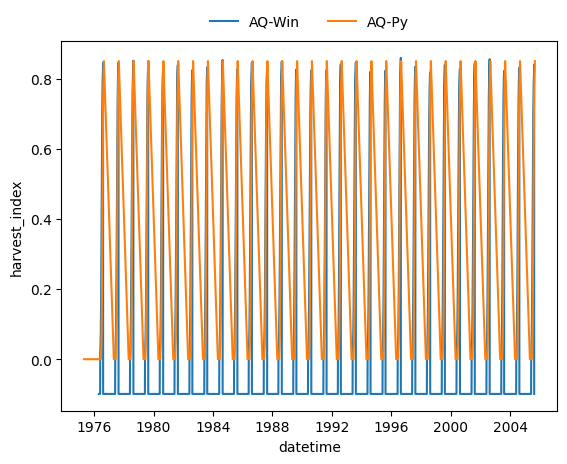

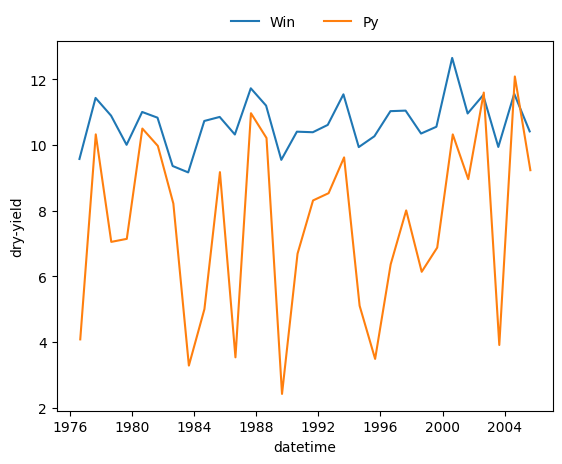

In [29]:
# create model with IrrMethod= Constant depth
model = AquaCropModel(sim_start_time=f'{1976}/03/01',
                      sim_end_time=f'{2005}/12/31',
                      weather_df=brussels_weather,
                      soil=loamy_sand,
                      crop=potato,
                      irrigation_management=IrrigationManagement(irrigation_method=5,),
                      initial_water_content=fc,
                      )
                       

model._initialize()

while model._clock_struct.model_is_finished is False:    
    # get depth to apply
    depth=get_depth(model,1.5)
    
    model._param_struct.IrrMngt.depth=depth

    model.run_model(initialize_model=False)

run_comparison('Bru_Pot_Irr150RAW', model)

9.6 Climate change impact

Historical:

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:71: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


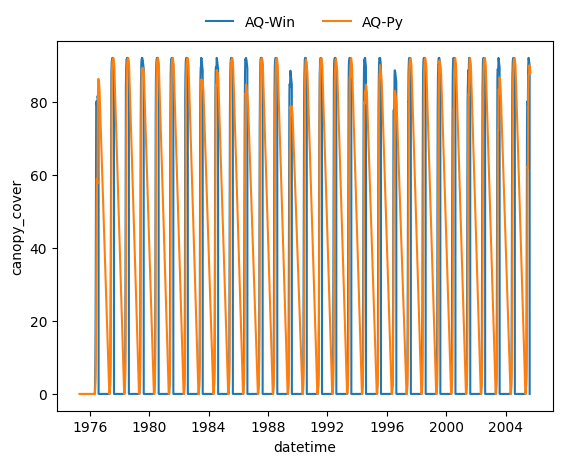

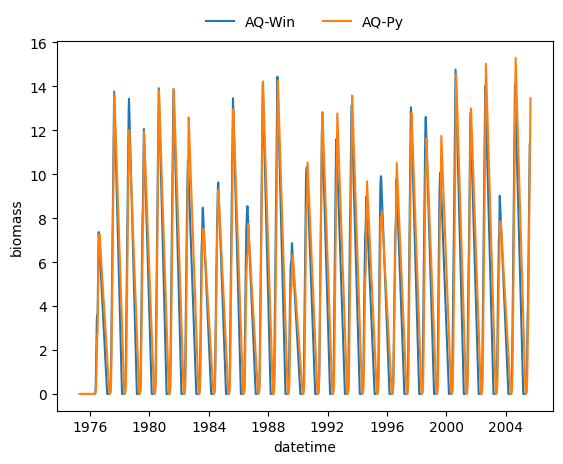

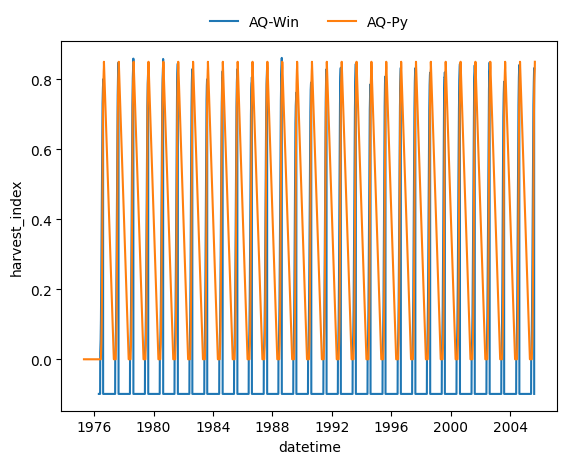

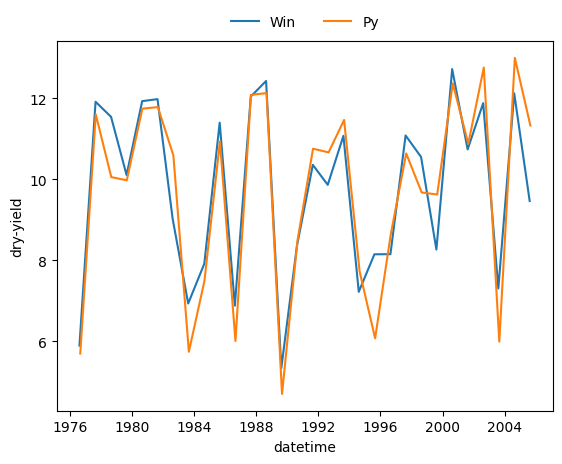

In [30]:
# Hist climate
filepath=get_filepath('brussels_climate.txt')
brussels_weather = prepare_weather(filepath)

# Local Brussels soil
loam_soil = Soil(soil_type='Loam')

# crops
potato = Crop('PotatoLocal', planting_date='04/25')

# IWC
fc = InitialWaterContent(value=['FC'])

# irr management
irr_mngt = IrrigationManagement(irrigation_method=0)

model = AquaCropModel(sim_start_time=f'{1976}/03/01',
                      sim_end_time=f'{2005}/12/31',
                      weather_df=brussels_weather,
                      soil=loam_soil,
                      crop=potato,
                      irrigation_management=irr_mngt,
                      initial_water_content=fc,
                      )
model.run_model(till_termination=True)

run_comparison('Bru_Pot_Historical', model)

Future:

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20876\4103452032.py:71: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


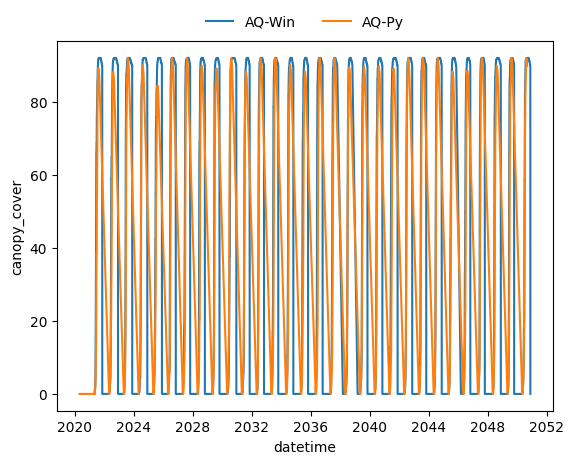

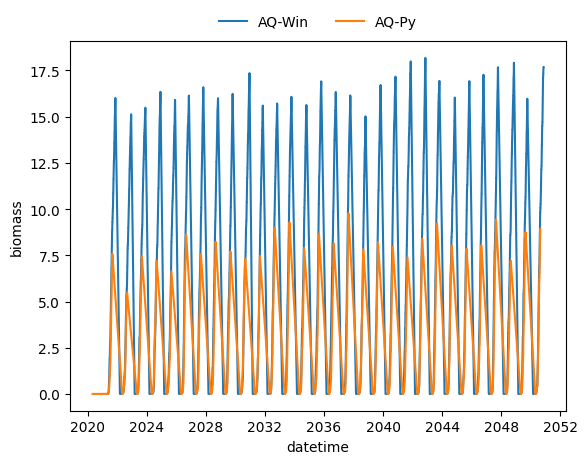

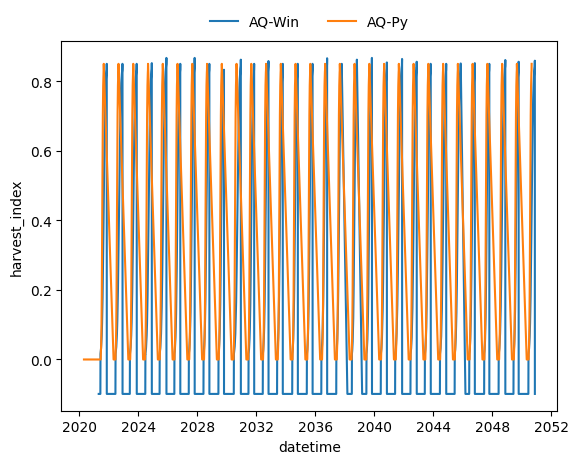

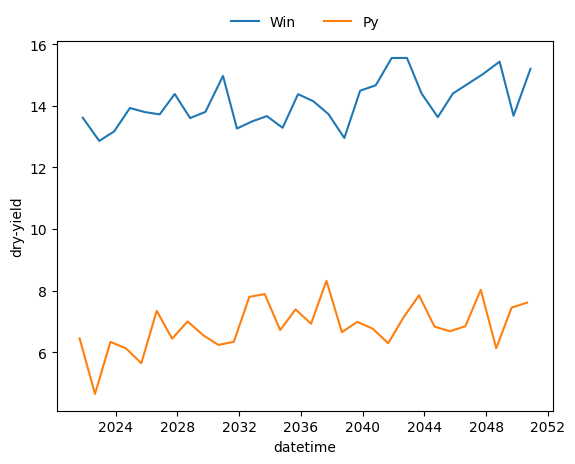

In [31]:
# Future climate
filepath=get_filepath('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/aquacrop/aquacrop/data/brussels_future.txt')
brussels_future = prepare_weather(filepath)

model = AquaCropModel(sim_start_time=f'{2021}/01/01',
                      sim_end_time=f'{2050}/12/31',
                      weather_df=brussels_future,
                      soil=loam_soil,
                      crop=potato,
                      irrigation_management=irr_mngt,
                      initial_water_content=fc,
                      )
model.run_model(till_termination=True)

run_comparison('Bru_Pot_Future2', model)

In [32]:
future_eto=pd.read_csv('../../AquaCrop-windows/AquaCropV7.1/DATA/Bru_Pot_Future2py.ETo')
future_temp=pd.read_table('../../AquaCrop-windows/AquaCropV7.1/DATA/Bru_Pot_Future2py.Tnx')
future_precip=pd.read_table('../../AquaCrop-windows/AquaCropV7.1/DATA/Bru_Pot_Future2py.PLU')

temp=future_eto.join(future_temp)
future_clim=temp.join(future_precip)
future_clim['datetime']=pd.date_range('2021/01/01','2050/12/31')
future_clim['Year']=pd.DatetimeIndex(future_clim['datetime']).year
future_clim['Month']=pd.DatetimeIndex(future_clim['datetime']).month
future_clim['Day']=pd.DatetimeIndex(future_clim['datetime']).day

future_clim.rename(columns={
    'Tmin (C)' : 'Tmin(C)',
    'TMax (C)' : 'Tmax(C)',
    'Average ETo (mm/day)' : 'Et0(mm)',
    'Total Rain (mm)' : 'Prcp(mm)'
},
inplace=True    
)

future_clim.drop('datetime',axis=1,inplace=True)
col_order=['Day', 'Month','Year','Tmin(C)','Tmax(C)','Prcp(mm)','Et0(mm)']
future_clim=future_clim[col_order]

future_clim.to_csv('brussels_future.txt', sep='\t')
%pwd
print(future_clim)


       Day  Month  Year  Tmin(C)  Tmax(C)  Prcp(mm)  Et0(mm)
0        1      1  2021     11.7     19.1      62.6      5.4
1        2      1  2021    -15.9     -8.8      13.5      5.9
2        3      1  2021    -11.2     -9.4      44.1      8.3
3        4      1  2021      9.3     18.6      30.5      2.6
4        5      1  2021      5.0     13.7      54.6      6.7
...    ...    ...   ...      ...      ...       ...      ...
10952   27     12  2050      2.1     10.1      50.0      9.1
10953   28     12  2050     20.7     22.4      17.7     12.6
10954   29     12  2050    -12.5     -4.0      41.1      9.7
10955   30     12  2050    -11.8     -7.8      37.9     12.7
10956   31     12  2050     13.3     22.8      21.3      4.8

[10957 rows x 7 columns]


In [33]:
pwd

'c:\\Users\\s10034cb\\Dropbox (The University of Manchester)\\Manchester Postdoc\\aquacrop\\tests'